In [1]:
import numpy as np
import SimpleITK as sitk
import gc
import sys
import os
import logging
from color_conversion import cv2_grey_to_color
from dataclasses import dataclass

logger = logging.getLogger("pre_process")


@dataclass
class image_preparation:
    r""" """

    def __init__(
        self,
        image_path,
        window_level=-600,
        window_width=1500,
        cormack_level=False,
        image_window=True,
        image_size=[256, 256, 256],
    ):

        self.raw_image = image_path
        self.window_level = window_level
        self.window_width = window_width
        self.cormack_level = cormack_level
        if self.cormack_level:
            self.window_level = 0
            self.window_width = 2000

        self.image_window = image_window
        self.image_size = image_size

        try:
            self.image, self.image2= self.loadImage()
        except:
            logger.error("File {} not found or not supported!".format(self.raw_image))

    def __del__(self):
        logger.info("Image pre-process destructor Called!")

    @staticmethod
    def _prepare_size(image_path, downsample_rate):
        Size = image_path.GetSize() / downsample_rate
        return Size

    def getImage(self):
        """
        Returns the image in the SimpleITK object format.
        """
        return self.image

    def setWindowLevel(self, value):
        """
        Sets the minimum window value.
        """
        self.window_level = value

    def setWindowWidth(self, value):
        """
        Sets the maximum window value.
        """
        self.window_width = value

    def setScaleCormack(self, flag):
        """
        Sets the Boolean value indicating whether or not the Hounsfield scale
        conversion to Cormack level will be performed.
        """
        self.cormack_level = flag

    def setImageWindow(self, flag):
        """
        Sets the Boolean value indicating whether or not the image will be
        windowed.
        """
        self.image_window = flag

    def hounsfield_to_cormack(self, image) -> sitk.Image:
        r"""Conversion formula suggested by Chris Rorden
        in matlab's clinical toolbox
        https://www.nitrc.org/projects/clinicaltbx/

        Parameters
        ----------
        image : SimpleITK image object
            Raw CT scan (Hounsfield scale)
        Returns
        -------
        type:
            SimpleITK image object.
        describe :
            Cormack scaled CT scan
        """
        img_data = sitk.GetArrayFromImage(image)
        t = img_data.flatten()
        t1 = np.zeros(t.size)
        t1[np.where(t > 100)] = t[np.where(t > 100)] + 3000
        t1[np.where(np.logical_and(t >= -1000, t <= -100))] = (
            t[np.where(np.logical_and(t >= -1000, t <= -100))] + 1000
        )
        t1[np.where(np.logical_and(t >= -99, t <= 100))] = (
            t[np.where(np.logical_and(t >= -99, t <= 100))] + 99
        ) * 11 + 911
        trans_img = t1.reshape(img_data.shape)

        res_img = sitk.GetImageFromArray(trans_img)
        res_img.CopyInformation(image)

        return res_img

    def imageWindow(self, image) -> sitk.Image:
        r"""A one-line summary that does not use variable names or the
        function name.
        Several sentences providing an extended description. Refer to
        variables using back-ticks, e.g. `var`.

        Parameters
        ----------
        image : array_like
            Array_like means all those objects -- lists, nested lists, etc. --
            that can be converted to an array.  We can also refer to
            variables like `var1`.
        Returns
        -------
        type
            Explanation of anonymous return value of type ``type``.
        describe : type
            Explanation of return value named `describe`.
        out : type
            Explanation of `out`.
        Other Parameters
        ----------------
        only_seldom_used_keywords : type
            Explanation
        common_parameters_listed_above : type
            Explanation
        """
        if self.cormack_level:
            image = self.hounsfield_to_cormack(image)
            logger.info("Cormack level selected")

        windowing = sitk.IntensityWindowingImageFilter()
        windowing.SetWindowMinimum(self.window_level)
        windowing.SetWindowMaximum(self.window_width)
        img_win = windowing.Execute(image)

        return img_win

    def loadImage(self) -> sitk.Image:
        """ """
        # Reads the image using SimpleITK
        image = sitk.ReadImage(self.raw_image)
        # Performs linear windowing
        if self.image_window:
            ct_image = self.imageWindow(image)
        else:
            ct_image = image
        # ct_array = sitk.GetArrayFromImage(itkimage)
        # Performs downsampling for Deep Learning purpouse
        ct_image2 = self.downsampleImage(ct_image)
        logger.info(str(ct_image.GetSize()))

        return ct_image,ct_image2

    def downsampleImage(self, image) -> sitk.Image:
        r"""Downsample funtion for deep learning preprocess purpose image
        reference_size: size in vector like format (i.e. [sx, sy,sz])
        Parameters
        ----------
        image : SimpleITK image object
            Windowed CT scan
        Returns
        -------
        type:
            SimpleITK image object.
        describe :
            Downsampled CT scan
        """
        original_CT = image
        # NIfTi(RAS) to ITK(LPS)
        original_CT = sitk.DICOMOrient(original_CT, "LPS")
        dimension = original_CT.GetDimension()
        reference_physical_size = np.zeros(original_CT.GetDimension())
        reference_physical_size[:] = [
            (sz - 1) * spc if sz * spc > max_ else max_
            for sz, spc, max_ in zip(
                original_CT.GetSize(), original_CT.GetSpacing(), reference_physical_size
            )
        ]

        reference_origin = original_CT.GetOrigin()
        reference_direction = original_CT.GetDirection()
        # NOTE: Looks like the downsampled image is mirrored over the y axis
        #     reference_direction = [1.,0.,0.,0.,1.,0.,0.,0.,1.]
        reference_size = self.image_size
        logger.info(str(reference_size))
        reference_spacing = [
            phys_sz / (sz - 1)
            for sz, phys_sz in zip(reference_size, reference_physical_size)
        ]

        reference_image = sitk.Image(reference_size, original_CT.GetPixelIDValue())
        reference_image.SetOrigin(reference_origin)
        reference_image.SetSpacing(reference_spacing)
        reference_image.SetDirection(reference_direction)

        reference_center = np.array(
            reference_image.TransformContinuousIndexToPhysicalPoint(
                np.array(reference_image.GetSize()) / 2.0
            )
        )

        transform = sitk.AffineTransform(dimension)
        transform.SetMatrix(original_CT.GetDirection())
        transform.SetTranslation(np.array(original_CT.GetOrigin()) - reference_origin)
        # Modify the transformation to align the centers of the original and
        # reference image instead of their origins.
        centering_transform = sitk.TranslationTransform(dimension)
        img_center = np.array(
            original_CT.TransformContinuousIndexToPhysicalPoint(
                np.array(original_CT.GetSize()) / 2.0
            )
        )
        centering_transform.SetOffset(
            np.array(
                transform.GetInverse().TransformPoint(img_center) - reference_center
            )
        )
        centered_transform = sitk.CompositeTransform([transform, centering_transform])

        return sitk.Resample(
            original_CT, reference_image, centered_transform, sitk.sitkLinear, 0.0
        )

    def gantryRemoval(self, ct_image) -> sitk.Image:
        r"""Intensity based tight crop

        Parameters
        ----------
        ct_image : SimpleITK image object
            Raw CT scan (Hounsfield scale)
        Returns
        -------
        type:
            SimpleITK image object.
        describe :
            tight cropped CT scan
        """
        max_hu = int(np.max(sitk.GetArrayFromImage(ct_image)))
        min_hu = int(np.min(sitk.GetArrayFromImage(ct_image)))
        # binary mask of chest + artifact(s)
        image_thr = sitk.BinaryThreshold(ct_image, -600, max_hu)
        # label image with connected components
        cc = sitk.ConnectedComponent(image_thr)
        # reorder labels with largest components first
        cc = sitk.RelabelComponent(cc)
        # get the first component (chest)
        cc = sitk.BinaryThreshold(cc, 1, 1)
        #  erode and dilate to denoise
        chestMask = sitk.BinaryMorphologicalOpening(cc, [2] * 3)
        # apply mask on image and return
        tmp_img = sitk.Mask(ct_image, chestMask, min_hu)

        return tmp_img
    

ModuleNotFoundError: No module named 'color_conversion'

In [2]:
import cv2
def fill_holes(mask):
    # Copy the mask to preserve the original
    filled_mask = mask.copy()

    # Perform morphological closing to fill the holes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    filled_mask = cv2.morphologyEx(filled_mask, cv2.MORPH_CLOSE, kernel)

    return filled_mask
def trimmer(image,image_mask,threshold:int=3000):
    x=np.where(image_mask.sum(axis=(0,1))>threshold)[0]
    y=np.where(image_mask.sum(axis=(1,2))>threshold)[0]
    z=np.where(image_mask.sum(axis=(0,2))>threshold)[0]
    return image[y[0]:y[-1],z[0]:z[-1],x[0]:x[-1]]

In [16]:
import glob
import os
import nibabel as nib

path_to_change="results_folder/unet_CT_SS_2023528_123217/predictions"
#path_to_change="predictions"
path="/home/abdullah/BOUN/MIPA/MIPA/CT_BET/results_folder/unet_CT_SS_2023528_123217/predictions/*.nii"
def window_image(img, window_center,window_width, intercept=None, slope=None, rescale=True,hu_conv=False):
    if hu_conv:
        img = (img*slope +intercept) #for translation adjustments given in the dicom file. 
    img_min = window_center - window_width//2 #minimum HU level
    img_max = window_center + window_width//2 #maximum HU level
    img=img*(img<img_max)*(img>img_min)
    
    print(img_min,img_max)

    if rescale: 
        img = (img - img_min) / (img_max - img_min)*255.0 
    return img

files=[]
images=[]
maskeds=[]
masks=[]
affines=[]import nibabel as nib
data=nib.load("1.2.410.200010.20230508.145831.100041/1.2.410.200010.20230508.145831.100041.124908/AXIAL/1.2.410.200010.20230508.145831.100041.124908_Beyin+Boyun_Anjio_Head_20230504005400_702.nii")
image_data=data.get_fdata()
def window(image,wl,ww,threshold):
    high_bound=wl+ww/2
    low_bound=wl-ww/2
    mask=np.clip(image,low_bound,high_bound,0,1)
    mask2=image<threshold
    return (image*mask*mask2)
image_filtered=window(image_data,50,120,231)
    try:
        #image_brain=image_preparation(file.replace(path_to_change,'transfer_data'),window_level=40,window_width=80)
        #image_brain.setImageWindow(True)
        #image_gantry=image_brain.gantryRemoval(image_brain.image)
        
        seg=nib.load(file)
        #image=sitk.GetArrayFromImage(image_gantry)    
    
        seg_data=seg.get_fdata()
        image=nib.load(file.replace(path_to_change,'transferdata'))
        image_data=image.get_fdata()
        masked=image_data*seg_data
        affines.append(image.affine)
        headers.append(image.header)
        files.append(file)
        masks.append(seg_data)
        images.append(image)
        masked=trimmer(masked,seg_data)
        flipped_image=(masked*(masked>1)).transpose(1,0,2)
        flipped_image = np.flip(flipped_image, axis=1)
        maskeds.append(flipped_image)
    except Exception as e: 
        print(file,e)
        pass

/home/abdullah/BOUN/MIPA/MIPA/CT_BET/results_folder/unet_CT_SS_2023528_123217/predictions/1.2.410.200010.20230510.150224.131209.120217_BEYIN_BT_Head_20230409171405_203.nii index 0 is out of bounds for axis 0 with size 0
/home/abdullah/BOUN/MIPA/MIPA/CT_BET/results_folder/unet_CT_SS_2023528_123217/predictions/1.2.410.200010.20230510.150106.132315.131483_BEYIN_BT_Head_20230405115322_203.nii index 0 is out of bounds for axis 0 with size 0
/home/abdullah/BOUN/MIPA/MIPA/CT_BET/results_folder/unet_CT_SS_2023528_123217/predictions/1.2.410.200010.20230509.190600.110909.129091_Beyin+Boyun_Anjio_Head_20230502034054_300.nii index 0 is out of bounds for axis 0 with size 0
/home/abdullah/BOUN/MIPA/MIPA/CT_BET/results_folder/unet_CT_SS_2023528_123217/predictions/1.2.410.200010.20230509.193305.117351.119983_BEYIN_BT_Head_20230403153409_203.nii index 0 is out of bounds for axis 0 with size 0
/home/abdullah/BOUN/MIPA/MIPA/CT_BET/results_folder/unet_CT_SS_2023528_123217/predictions/1.2.410.200010.202305

: 

In [14]:
for idx,imagx in enumerate(maskeds):
    try:
        os.mkdir('outputs2')
    except:
        pass
    img = nib.Nifti1Image(imagx, images[idx].affine, images[idx].header)
    nib.save(img,f'outputs2/patient{idx}.nii.gz')

In [219]:
len(glob.glob(path))

18

In [1]:
import nibabel as nib
seg=nib.load('/home/abdullah/BOUN/MIPA/MIPA/CT_BET/results_folder/unet_CT_SS_2023528_123217/predictions/1.2.410.200010.20230508.145831.100041.127011_Beyin+Boyun_Anjio_Head_20230504005400_201.nii')

In [2]:
im=nib.load("/home/abdullah/BOUN/MIPA/MIPA/transfer_data22/deneme.nii")

In [3]:
im_d=im.get_fdata()
seg_d=seg.get_fdata()

In [7]:
masked=im_d[:,:,0:119]*seg_d

In [39]:
def fill_holes(mask):
    # Copy the mask to preserve the original
    filled_mask = mask.copy()

    # Perform morphological closing to fill the holes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
    filled_mask = cv2.morphologyEx(filled_mask, cv2.MORPH_CLOSE, kernel)
    return filled_mask

In [53]:
def erode_and_fill(mask):
    for idx,m in enumerate(mask):
        kernel = np.ones((20, 20), np.uint8)  # Adjust the kernel size as needed
        filled_mask = fill_holes(m)
        eroded_mask = cv2.erode(filled_mask, kernel, iterations=1)
        
        mask[idx,:,:] = eroded_mask
    return mask

In [54]:
import numpy as np
import nibabel as nib
from nibabel import processing
import cv2
data=nib.load("1.2.410.200010.20230508.145831.100041/1.2.410.200010.20230508.145831.100041.124908/AXIAL/1.2.410.200010.20230508.145831.100041.124908_Beyin+Boyun_Anjio_Head_20230504005400_702.nii")
mask=nib.load("CT_BET/results_folder/unet_CT_SS_2023529_145121/predictions/deneme2.nii")
data=processing.smooth_image(data,3)
image_data=data.get_fdata()
def window(image,wl,ww,threshold,mask):
    high_bound=wl+(ww/2)
    low_bound=wl-(ww/2)
    eroded_mask = erode_and_fill(mask)

    mask1=(image<high_bound)*(image>low_bound)
    mask2=(image<threshold)*(image>50)
    
    return (mask1+mask2)*eroded_mask,(image)*(mask1+mask2),eroded_mask
image_filtered,org,eroded_mask=window(image_data,60,20,200,mask.get_fdata())

In [55]:
maskc=nib.Nifti1Image(image_filtered,data.affine,data.header)
nib.save(maskc,'outputs2/vessels.nii')

: 

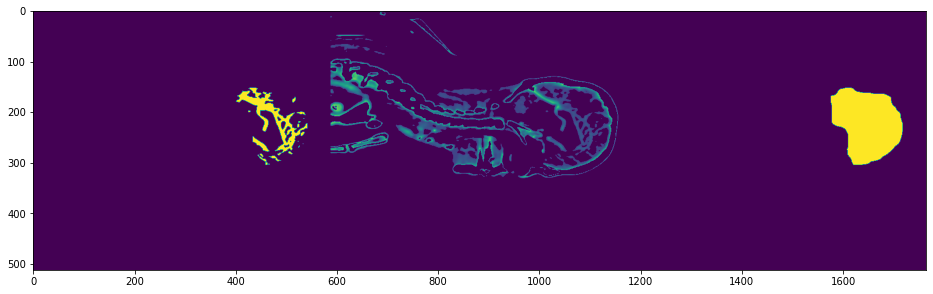

In [49]:
from matplotlib import pyplot as plt 
plt.figure(figsize=(16,16))
slice=252
plt.imshow(np.hstack((255*image_filtered[slice,:,:],org[slice,:,:],255*fill_holes(eroded_mask[slice,:,:]))))

In [9]:
image_filtered.min()

-9.0